In [136]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

### Load the dataset

In [137]:
import sys
sys.path.append('/export/home/mirror_pylmnn')

In [138]:
import importlib
import pylmnn.dataset.load_dataset as load_dataset #_dataset_verification
importlib.reload(load_dataset)
data_path = '/export/home/loreal_135_classification'
image_dict, label2id = load_dataset._dataset_verification(data_path)

sample statistics: 
LabelI LabelName                      # samples           
====== ============================== ====================
22     effaclar_foam_gel_400_in       16                  
20     lrp_tin                        19                  
21     effaclar_k_40_out              39                  
10     toleriane_creme_out            44                  
11     lipikar_balm_ap_200_out        44                  
18     rosaliac_ar_intense_out        44                  
7      toleriane_yeux_out             49                  
16     effaclar_k_40_in               58                  
6      cicaplast_balm_40_in           64                  
5      cicaplast_balm_40_out          70                  
9      toleriane_creme_in             72                  
19     effaclar_duo_40_out            76                  
8      toleriane_yeux_in              77                  
4      rosaliac_ar_intense_in         79                  
17     lipikar_balm_ap_200_in       

### keep classes that have 100 samples 

In [139]:
num_samples = 100
balanced_dataset = load_dataset._normalize_dataset(image_dict, num_samples)

sample statistics: 
Label                          # of samples   
============================== ===============
effaclar_duo_40_in             100            
effaclar_foam_gel_200_in       100            
lipikar_balm_ap_400_in         100            
lipikar_syndet_400_in          100            
lrp_bottle                     100            
lrp_box                        100            
lrp_tube                       100            
price_tag                      100            


In [140]:
num_training = 50
data = load_dataset._dataset_split_fewshot(balanced_dataset, num_training)

sample statistics: 
Label                          Train           Test           
============================== =============== ===============
effaclar_duo_40_in             50              50             
effaclar_foam_gel_200_in       50              50             
lipikar_balm_ap_400_in         50              50             
lipikar_syndet_400_in          50              50             
lrp_bottle                     50              50             
lrp_box                        50              50             
lrp_tube                       50              50             
price_tag                      50              50             


### Visualize the training samples and test samples

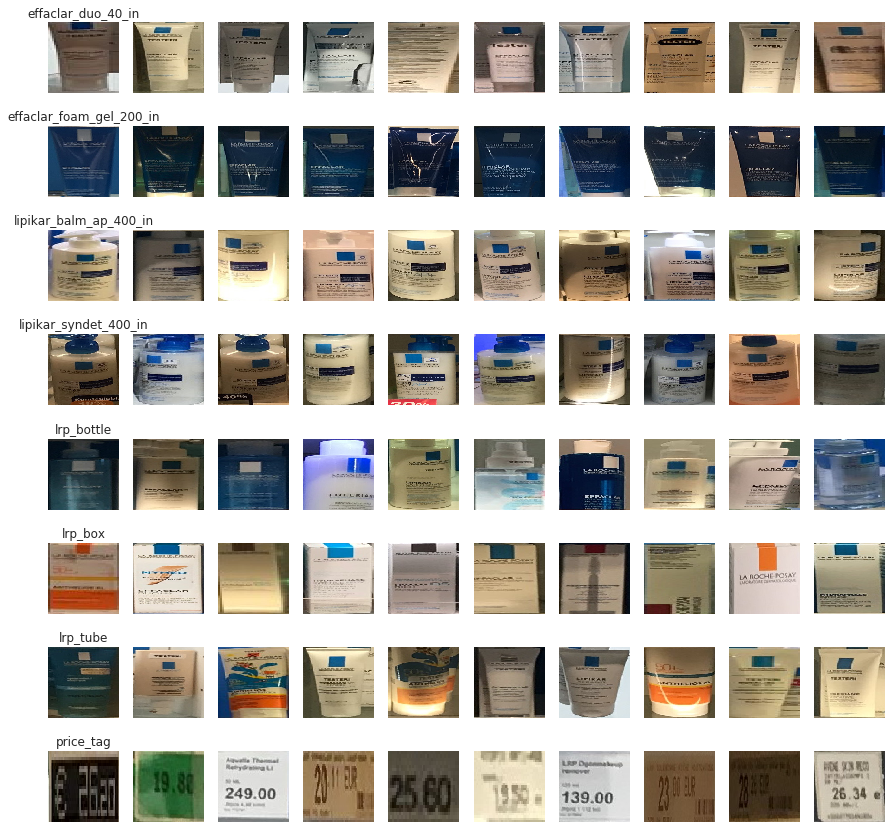

In [141]:
train_set = data['train']
test_set = data['test']

classes = train_set.keys()
num_classes = len(classes)
samples_per_class = 10

plt.figure(figsize=(15, 15))
for y, cls in enumerate(classes):
    idxs = [i for i in range(len(train_set[cls]))]
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = y * samples_per_class + i + 1
        plt.subplot(num_classes, samples_per_class, plt_idx)
        img = Image.open(train_set[cls][idx])
        img = np.array(img.resize((224, 224)))
        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### Fine tune resnet101 on the training set

In [143]:
import importlib
import pylmnn.embeddings.create_embeddings as create_embeddings
importlib.reload(create_embeddings)

train_overrides = {'num_cols': 224,
                   'num_rows': 224,
                   'num_epochs': 50,
                   'training_batch_size': 16}

train_cfg = create_embeddings.ClassConfig(train_overrides)

data_labels = create_embeddings.sort_and_dedup(train_set.keys())
print(data_labels)

training_generator = create_embeddings.DataGenerator(dataset=train_set, labels=data_labels,
                                           batch_size=train_cfg.training_batch_size,
                                           dim=(train_cfg.num_rows, train_cfg.num_cols),
                                           num_channels=train_cfg.num_channels, shuffle=True)
validation_generator = create_embeddings.DataGenerator(dataset=test_set, labels=data_labels,
                                             batch_size=train_cfg.training_batch_size,
                                             dim=(train_cfg.num_rows, train_cfg.num_cols),
                                             num_channels=train_cfg.num_channels, shuffle=True)

cls_trainer = create_embeddings.ClassificationTrainer(labels=data_labels, config=train_cfg)

history = cls_trainer.train_resnet101(training_generator=training_generator,
                                    validation_generator=validation_generator)

('effaclar_duo_40_in', 'effaclar_foam_gel_200_in', 'lipikar_balm_ap_400_in', 'lipikar_syndet_400_in', 'lrp_bottle', 'lrp_box', 'lrp_tube', 'price_tag')
0
0
Training Classification Model...
Epoch 1/50
23/25 [==========================>...] - ETA: 2s - loss: 2.2631 - acc: 0.17930
0
25/25 [==============================] - 32s 1s/step - loss: 2.2636 - acc: 0.1775 - val_loss: 2.4819 - val_acc: 0.1000

Epoch 00001: acc improved from -inf to 0.17750, saving model to resnet101.hdf5


KeyboardInterrupt: 

### Training/Test Curve and accuracy

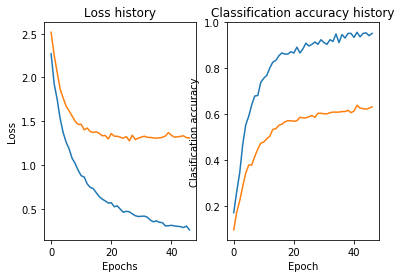

In [84]:
stats = history.history
# Plot the loss function and train / validation accuracies
plt.subplot(1, 2, 1)
plt.plot(stats['loss'], label='train')
plt.plot(stats['val_loss'], label='test')
plt.title('Loss history')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(stats['acc'], label='train')
plt.plot(stats['val_acc'], label='test')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

### CNN feature extraction

In [114]:
importlib.reload(create_embeddings)

feature_training_generator = create_embeddings.DataGenerator(dataset=train_set, labels=data_labels,
                                            batch_size=train_cfg.training_batch_size,
                                            dim=(train_cfg.num_rows, train_cfg.num_cols),
                                            num_channels=train_cfg.num_channels, collect_labels=True)

feature_validation_generator = create_embeddings.DataGenerator(dataset=test_set, labels=data_labels,
                                            batch_size=train_cfg.training_batch_size,
                                            dim=(train_cfg.num_rows, train_cfg.num_cols),
                                            num_channels=train_cfg.num_channels, collect_labels=True)

feature_training = cls_trainer.extract_feature(data_generator=feature_training_generator)
label_training = np.array(feature_training_generator.class_indexes)
np.savez_compressed(os.path.join(data_path, 'em_training.npz'), X=feature_training, y=label_training)

feature_validation = cls_trainer.extract_feature(data_generator=feature_validation_generator)
label_validation = np.array(feature_validation_generator.class_indexes)
np.savez_compressed(os.path.join(data_path, 'em_test.npz'), X=feature_validation, y=label_validation)

0
0
25/25 [==============================] - 12s 473ms/step


### Visualize embedding on CNN feature

(400, 2048)
(400,)


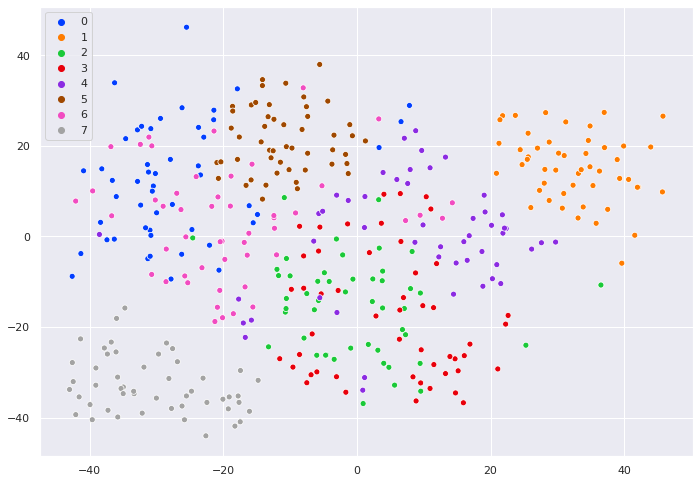

In [130]:
print(feature_training.shape)
print(label_training.shape)

from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 8)

tsne = TSNE()
X_embedded_train = tsne.fit_transform(feature_training)

sns.scatterplot(X_embedded_train[:,0], X_embedded_train[:,1], hue=label_training, legend='full', palette=palette)

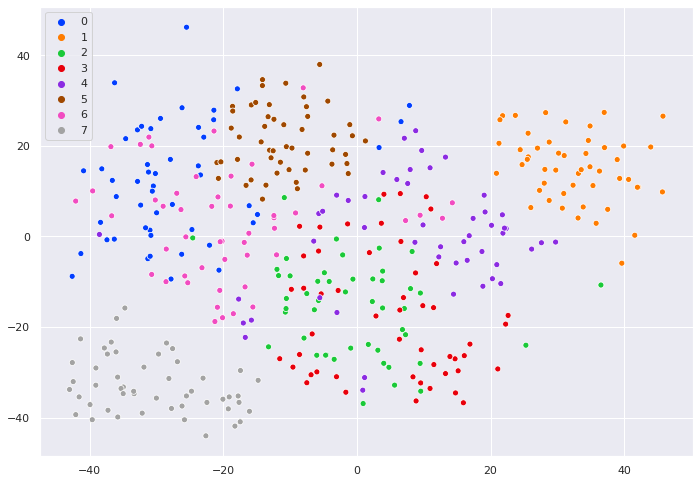

In [131]:
X_embedded_test = tsne.fit_transform(feature_validation)

sns.scatterplot(X_embedded_test[:,0], X_embedded_test[:,1], hue=label_validation, legend='full', palette=palette)


### Nearest Neighbor Raw

In [133]:
from sklearn.neighbors import KNeighborsClassifier
from pylmnn import LargeMarginNearestNeighbor
knn = KNeighborsClassifier(n_neighbors=10)

# Train with no transformation (euclidean metric)
knn.fit(feature_training, label_training)

# Test with euclidean metric
acc = knn.score(feature_validation, label_validation)

print('KNN accuracy on test set: {}'.format(acc))

KNN accuracy on test set: 0.7525


### Large Margin Nearest Neighbor

In [135]:
# LMNN is no longer a classifier but a transformer
lmnn = LargeMarginNearestNeighbor(n_neighbors=10, verbose=1, max_iter=300)
lmnn.fit(feature_training, label_training)

# Train with transformation learned by LMNN
knn.fit(lmnn.transform(feature_training), label_training)

# Test with transformation learned by LMNN
acc = knn.score(lmnn.transform(feature_validation), label_validation)

print('LMNN accuracy on test set: {}'.format(acc))

[LargeMarginNearestNeighbor] Finding principal components...
[LargeMarginNearestNeighbor] Found principal components in  6.14s.
[LargeMarginNearestNeighbor] Finding the target neighbors...
[LargeMarginNearestNeighbor] Found the target neighbors in  0.26s.
[LargeMarginNearestNeighbor] Computing static part of the gradient...
[LargeMarginNearestNeighbor] Computed static part of the gradient in  0.04s.
[LargeMarginNearestNeighbor]
[LargeMarginNearestNeighbor]  Iteration      Objective Value     #Active Triplets    Time(s)
[LargeMarginNearestNeighbor] ---------------------------------------------------------------
[LargeMarginNearestNeighbor]          1         6.088422e+08               25,949       1.00
[LargeMarginNearestNeighbor]          1         1.658527e+08               15,156       0.99
[LargeMarginNearestNeighbor]          2         1.062028e+08               11,917       0.95
[LargeMarginNearestNeighbor]          3         4.473991e+07                7,577       1.15
[LargeMarg

[LargeMarginNearestNeighbor]         21         1.833261e+06                  303       1.19
[LargeMarginNearestNeighbor]         21         1.844811e+06                  309       0.89
[LargeMarginNearestNeighbor]         21         1.833261e+06                  303       1.09
[LargeMarginNearestNeighbor]         21         1.833261e+06                  303       1.18
[LargeMarginNearestNeighbor]         21         1.833258e+06                  303       1.00
[LargeMarginNearestNeighbor]         21         1.844812e+06                  309       0.98
[LargeMarginNearestNeighbor]         21         1.833258e+06                  303       0.98
[LargeMarginNearestNeighbor]         21         1.833258e+06                  303       0.99
[LargeMarginNearestNeighbor]         21         1.844813e+06                  309       0.90
[LargeMarginNearestNeighbor]         21         1.833258e+06                  303       1.08
[LargeMarginNearestNeighbor]         21         3.366460e+33          

[LargeMarginNearestNeighbor]         75         1.303545e+03                    0       1.39
[LargeMarginNearestNeighbor]         76         1.114937e+03                    0       0.99
[LargeMarginNearestNeighbor]         77         8.944302e+02                    0       0.90
[LargeMarginNearestNeighbor]         78         7.215132e+02                    0       1.10
[LargeMarginNearestNeighbor]         79         6.330989e+02                    0       0.89
[LargeMarginNearestNeighbor]         80         5.406066e+02                    0       0.90
[LargeMarginNearestNeighbor]         81         4.707067e+02                    0       1.09
[LargeMarginNearestNeighbor]         82         3.886961e+02                    0       0.89
[LargeMarginNearestNeighbor]         83         3.295268e+02                    0       1.09
[LargeMarginNearestNeighbor]         84         2.815922e+02                    0       0.88
[LargeMarginNearestNeighbor]         85         2.433924e+02          

[LargeMarginNearestNeighbor]        162         1.148781e+00                    0       0.99
[LargeMarginNearestNeighbor]        163         9.416678e-01                    0       0.98
[LargeMarginNearestNeighbor]        164         1.277245e+00                    0       1.06
[LargeMarginNearestNeighbor]        164         8.541657e-01                    0       1.13
[LargeMarginNearestNeighbor]        165         7.336735e-01                    0       1.11
[LargeMarginNearestNeighbor]        166         6.584793e-01                    0       1.01
[LargeMarginNearestNeighbor]        167         5.435480e-01                    0       1.00
[LargeMarginNearestNeighbor]        168         5.159193e-01                    0       1.17
[LargeMarginNearestNeighbor]        169         4.159565e-01                    0       1.08
[LargeMarginNearestNeighbor]        170         3.768678e-01                    0       1.17
[LargeMarginNearestNeighbor]        171         3.278012e-01          

### Visualize embedding after LMNN learning

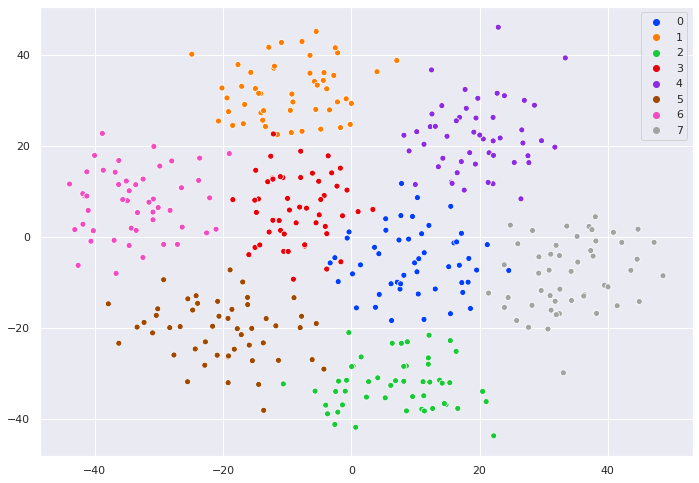

In [128]:
feature_embedded = lmnn.transform(feature_training)
#label_training
palette = sns.color_palette("bright", 8)

tsne = TSNE()
X_embedded = tsne.fit_transform(feature_embedded)

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=label_training, legend='full', palette=palette)


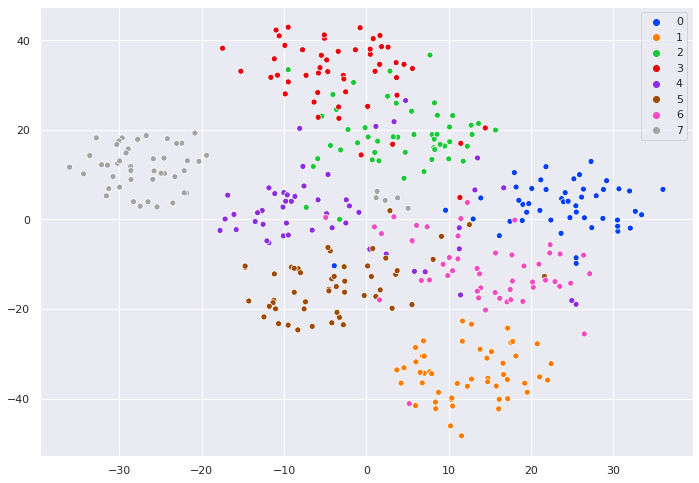

In [132]:
feature_embedded = lmnn.transform(feature_validation)
#label_training
palette = sns.color_palette("bright", 8)

tsne = TSNE()
X_embedded = tsne.fit_transform(feature_embedded)

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=label_validation, legend='full', palette=palette)